# Train cad/dog classifier based on a CNN

In [1]:
import cv2 as cv
import tensorflow as tf
import keras
import numpy as np
import os
from typing import Union
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Helper functions

In [2]:
def images_importer(path: str, file_extensions: Union[str, list], gray: bool = True, 
                    cropandresizeto: Union[None, list] = None,
                    limitto: Union[int, None] = None):
    flag = cv.IMREAD_GRAYSCALE if gray else None
    if isinstance(file_extensions, str):
        file_extensions = [file_extensions]
    file_names = os.listdir(path)
    images = []
    i = 0
    for file_name in file_names:
        if file_name.split('.')[-1] in file_extensions:
            im = cv.imread(os.path.join(path, file_name), flags=flag)
            if cropandresizeto is not None:
                half_size = int(min(im.shape[0:2]) // 2)
                half_rows, half_cols = int(im.shape[0]//2), int(im.shape[1]//2)
                if len(im.shape) == 3:
                    im = im[half_rows-half_size:half_rows+half_size, half_cols-half_size:half_cols+half_size, :]
                else:
                    im = im[half_rows-half_size:half_rows+half_size, half_cols-half_size:half_cols+half_size]
                im = cv.resize(im, cropandresizeto)
            images.append(im)
            i += 1
            if limitto is not None and i >= limitto:
                break
    return images

## Load images to construct training and test datasets

In [3]:
path_images_dogs = r"C:\Fotos y videos\cats_dogs\dogs"
path_images_cats = r"C:\Fotos y videos\cats_dogs\cats"
file_extensions = 'jpg'
resolution = [100, 100]

images_dogs = images_importer(path=path_images_dogs, file_extensions=file_extensions, gray=True, cropandresizeto=resolution, 
                              limitto=None)
images_cats = images_importer(path=path_images_cats, file_extensions=file_extensions, gray=True, cropandresizeto=resolution,
                              limitto=None)

In [4]:
# # Display some examples
# for i in range(5):
#     cv.imshow(f'Dog {i}', images_dogs[i])
#     cv.imshow(f'Cat {i}', images_cats[i])
# cv.waitKey(0)
# cv.destroyAllWindows()

In [5]:
# [images_dogs[i].shape for i in range(len(images_dogs))]

In [6]:
# [images_cats[i].shape for i in range(len(images_cats))]

# Labeling and Construct the training and test datasets

## Labeling

In [7]:
# Dataset
X_class0 = (np.array(images_dogs, dtype='float32')/255).reshape(-1, resolution[0], resolution[1], 1)
y_class0 = np.hstack((np.ones((X_class0.shape[0], 1)), np.zeros((X_class0.shape[0], 1))))
# print(X_class0.shape, y_class0.shape)
# print(y_class0)

X_class1 = (np.array(images_cats, dtype='float32')/255).reshape(-1, resolution[0], resolution[1], 1)
y_class1 = np.hstack((np.zeros((X_class1.shape[0], 1)), np.ones((X_class1.shape[0], 1))))
# print(X_class1.shape, y_class1.shape)
# print(y_class1)

X = np.vstack((X_class0, X_class1))
y = np.vstack((y_class0, y_class1))

# print(X.shape, y.shape)

X, y = shuffle(X, y, random_state=3)

# # Display some examples
# for i in range(10):
#     cv.imshow(f'{i}, Class {y[i]}', X[i])
# cv.waitKey(0)
# cv.destroyAllWindows()

## Dataset split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# # Display some examples
# for i in range(10):
#     cv.imshow(f'{i}, Class {y_train[i]}', X_train[i])
# cv.waitKey(0)
# cv.destroyAllWindows()

# for i in range(10):
#     cv.imshow(f'{i}, Class {y_test[i]}', X_test[i])
# cv.waitKey(0)
# cv.destroyAllWindows()

# Definition of the classifier model

In [9]:
learning_rate = 0.0001

model = keras.Sequential(
    [
        keras.layers.Input(shape=(resolution[0], resolution[1], 1)),
        keras.layers.Conv2D(16, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((4, 4)),
        keras.layers.Conv2D(8, (3, 3)),
        keras.layers.MaxPool2D((4,4)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)
model.summary()

model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.losses.binary_crossentropy, 
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 8)           0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 64)                1

## Training

In [10]:
train_flag = False
filepath = 'best_model_cats_dogs.h5'
if train_flag:
    batch_size = 16
    epochs = 100

    # Define the ModelCheckpoint callback
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=filepath,  # Specify the file to save the weights
        monitor='val_accuracy',      # Monitor a specific metric (e.g., validation accuracy)
        save_best_only=True,          # Save only the best model
        mode='max',                   # Mode can be 'max' or 'min' based on the monitored metric
        verbose=1)                    # Verbosity mode (optional)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

    history = model.fit(X_train, y_train[:,0], batch_size=batch_size, epochs=epochs, validation_split=0.1, 
                        callbacks=[checkpoint, lr_scheduler])
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
else:
    model.load_weights(filepath)

## Test

7/7 [==============================] - 1s 19ms/step - loss: 0.5935 - accuracy: 0.7094
Test Accuracy: 70.94%
7/7 [==============================] - 0s 19ms/step
Failures


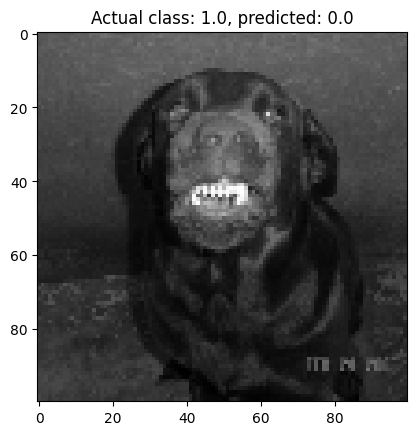

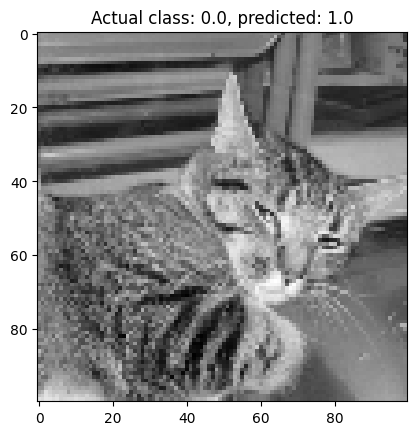

Hists


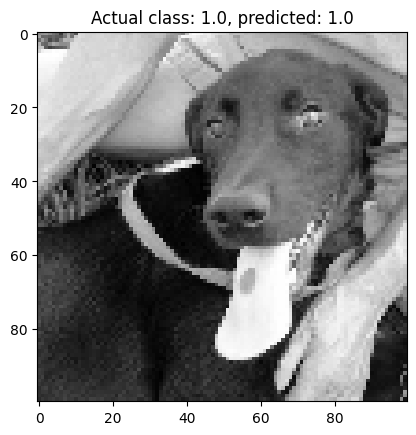

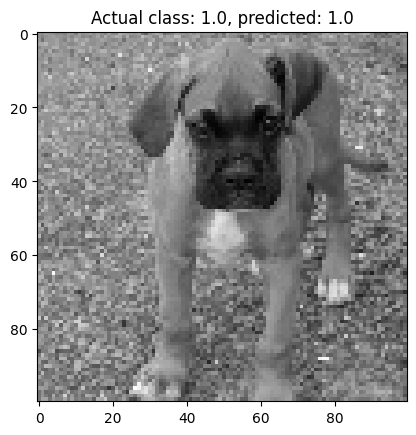

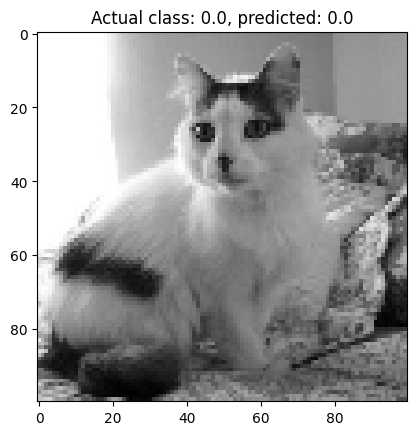

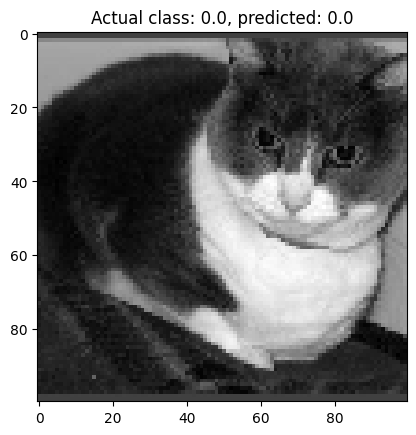

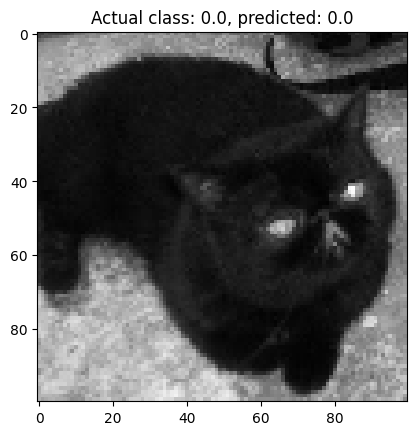

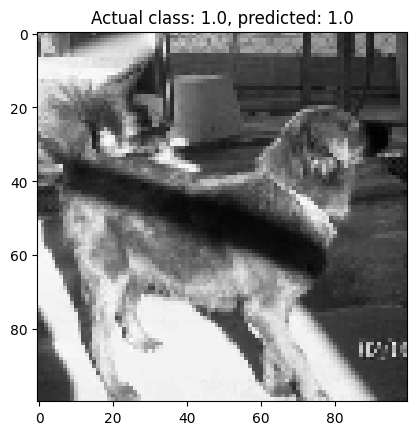

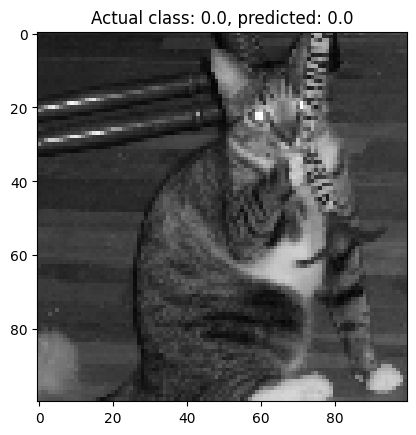

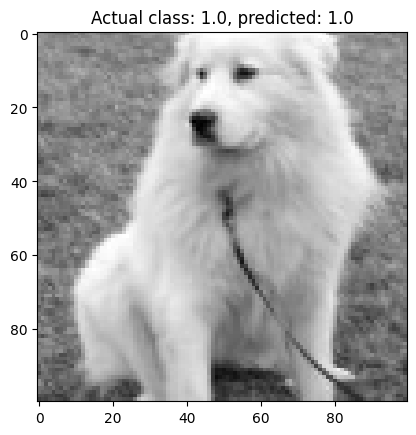

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test[:, 0])
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

min_test = 100
max_test = 110
comparison = np.hstack((y_test[:, 0].reshape(-1, 1), model.predict(X_test) > 0.5))
# print(comparison)

# Failures
print('Failures')
for i in range(min_test, max_test):
    if comparison[i][0] != comparison[i][1]:
        plt.imshow(X_test[i], cmap='gray')
        plt.title(f'Actual class: {comparison[i][0]}, predicted: {comparison[i][1]}')
        plt.show()

# Hits
print('Hists')
for i in range(min_test, max_test):
    if comparison[i][0] == comparison[i][1]:
        plt.imshow(X_test[i], cmap='gray')
        plt.title(f'Actual class: {comparison[i][0]}, predicted: {comparison[i][1]}')
        plt.show()

# Global descriptor from partial model

In [15]:
partial_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(model.layers[4].name).output)
partial_model.summary()
global_descriptor = lambda img_gray: partial_model.predict(np.reshape(img_gray, (1, resolution[0], resolution[1], 1))).reshape((1, -1))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 8)           0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200)               0   

In [16]:
database_indices = [i for i in range(200)]
database = np.array([global_descriptor(X_test[i, :, :]) for i in database_indices])[:,0,:]


1/1 [==============================] - 0s 27ms/step


# Content based image retrieval

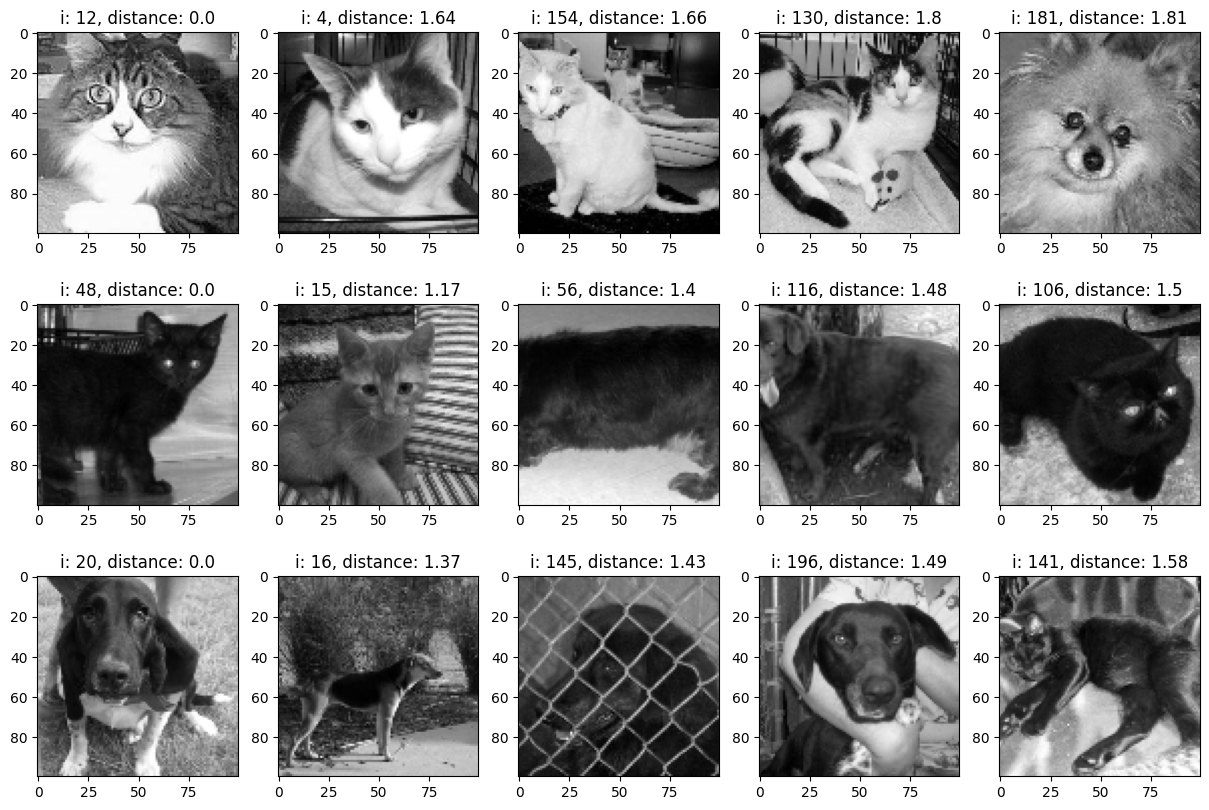

In [42]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)

query_images = [database[i_query, :].reshape(1, -1) for i_query in [12, 48, 20]]
k_results = 5
fig, ax = plt.subplots(len(query_images), k_results, figsize=(15,10))
for i_query in range(len(query_images)):
    matches = flann.knnMatch(query_images[i_query], database, k=k_results)    
    for i, match in enumerate(matches[0]):
        ax[i_query, i].imshow(X_test[match.trainIdx], 'gray')
        ax[i_query, i].set_title(f'i: {match.trainIdx}, distance: {np.round(match.distance, 2)}')
plt.show()